In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from scipy import stats
import statsmodels.api as sm

## Importer les données

In [174]:
bnc = pd.read_csv('C:/Users/gurkaali/Documents/Info/Ben/BNC/CSV Files/BNC.csv', sep=",")
demo = pd.read_csv('C:/Users/gurkaali/Documents/Info/Ben/BNC/CSV Files/demo.csv', sep=",")
market = pd.read_csv('C:/Users/gurkaali/Documents/Info/Ben/BNC/CSV Files/market.csv', sep=",")
web = pd.read_csv('C:/Users/gurkaali/Documents/Info/Ben/BNC/CSV Files/web.csv', sep=",")

## Contrôler les données

Tous les tableaux ont 2 colonnes avec le type 'object' : mois et client_id.
Seulement les 4 colonnes de volume dans le tableau 'bnc' ont des valeurs NULL. En raison du contexte, il est raisonable d'avoir des NULLs pour celles-ci

In [175]:
demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20500 entries, 0 to 20499
Data columns (total 14 columns):
MOIS               20500 non-null object
CLIENT_ID          20500 non-null object
homme              20500 non-null int64
courriel           20500 non-null int64
Langue_Francais    20500 non-null int64
naissance          20500 non-null int64
logement           20500 non-null int64
profession         20500 non-null int64
nb_enfant          20500 non-null int64
ville              20500 non-null int64
education          20500 non-null int64
age                20500 non-null int64
revenu             20500 non-null int64
revenu_foyer       20500 non-null int64
dtypes: int64(12), object(2)
memory usage: 2.2+ MB


In [176]:
market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20460 entries, 0 to 20459
Data columns (total 4 columns):
MOIS         20460 non-null object
CLIENT_ID    20460 non-null object
taux         20460 non-null float64
GDP          20460 non-null float64
dtypes: float64(2), object(2)
memory usage: 639.5+ KB


In [177]:
web.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20460 entries, 0 to 20459
Data columns (total 6 columns):
MOIS         20460 non-null object
CLIENT_ID    20460 non-null object
web_taux     20460 non-null int64
web_mls      20460 non-null int64
vol_taux     20460 non-null int64
vol_mls      20460 non-null int64
dtypes: int64(4), object(2)
memory usage: 959.1+ KB


In [178]:
bnc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20490 entries, 0 to 20489
Data columns (total 19 columns):
MOIS                  20490 non-null object
CLIENT_ID             20490 non-null object
pret_anterieur        20490 non-null int64
compte_commercial     20490 non-null int64
carte_MC              20490 non-null int64
NSF                   20490 non-null int64
PH_autre_FI           20490 non-null int64
sphere_epargne        20490 non-null int64
sphere_financement    20490 non-null int64
sphere_transaction    20490 non-null int64
nb_produit            20490 non-null int64
relation_BNC          20490 non-null int64
vol_MC                8291 non-null float64
vol_epargne           7136 non-null float64
vol_financement       5100 non-null float64
vol_transaction       19477 non-null float64
TEF                   20490 non-null int64
mono_produit          20490 non-null int64
PH                    20490 non-null int64
dtypes: float64(4), int64(13), object(2)
memory usage: 3.0+ MB


J'ai tenté de convertir les client_ID en chiffre sauf que la commande to_numeric produit une erreur car certains IDs ne sont pas numériques. 
Il y'en a également qui ne sont pas alphabétiques.
Parmis les lignes avec un contenu non-alphanumérique, les 10 premières suivantes contiennent également des symboles qui me fait soupconner. Pourtant, le reste (à partir de la 11e ligne) se présentente dans tous les tableaux. Il est ainsi raisonable de les garder.

In [179]:
bnc.CLIENT_ID[bnc['CLIENT_ID'].str.isnumeric() == False]

20457    00000000#03%80
20458    00000000#34346
20459    00000000#35#%0
20460    00000000#7x70#
20461    00000000#x340%
20462    00000000#x44xx
20463    000000003#xx80
20464    0000000037x%6x
20465    0000000057%#7%
20466    00000000847x00
20467    BERNG519780001
20468    BERNM688873001
20469    BLAND599677001
20470    BOUCG519576001
20471    CARRD499093001
20472    CHOLS408879001
20473    COWEB589273001
20474    DAUPM339680001
20475    FIDUP279577001
20476    GIGUC429594001
20477    GUAYF399380001
20478    MENAC359398001
20479    PERRA679780001
20480    RACIM409787001
20481    ROUSB569185001
20482    SAPUF669693001
20483    SARRJ548770001
20484    SAVAJ618997001
20485    SEERL399378001
20486    THERC309283001
20487    TURGY309579001
20488    TURNG419179001
20489    VASKM258880001
Name: CLIENT_ID, dtype: object

J'enlève les zéros au début des IDs pour une interprétation visuelle plus simple:

In [180]:
bnc.CLIENT_ID = [r.lstrip("0") for r in bnc.CLIENT_ID]
web.CLIENT_ID = [w.lstrip("0") for w in web.CLIENT_ID]
demo.CLIENT_ID = [d.lstrip("0") for d in demo.CLIENT_ID]
market.CLIENT_ID = [m.lstrip("0") for m in market.CLIENT_ID]

Je vérifie le nombre de fois les IDs apparaissent dans chaque tableau afin de mieux comprendre la liason entre les tableaux.
Je comprends que le tableau 'demo' est la liste principale avec les informations sur les clients. Je m'attends ainsi de voir chaque client une seule fois:

In [181]:
demo.groupby('CLIENT_ID')\
            .size() \
            .reset_index(name='count') \
            .sort_values(['count'], ascending = False) \
            .head()

,CLIENT_ID,count
1465,329153,2
12874,8995,2
2272,414974,2
2727,462230,2
11887,883034,2


Pourtant ce n'est pas le cas. Il se revèle qu'il y a des lignes entières qui sont repétées. J'enlève ainsi les doubles (subset = None):

In [182]:
demo.drop_duplicates(subset=None, keep='first', inplace=True)
bnc.drop_duplicates(subset=None, keep='first', inplace=True)
market.drop_duplicates(subset=None, keep='first', inplace=True)
web.drop_duplicates(subset=None, keep='first', inplace=True)

Suite a' l'élimination des lignes doubles, chaque client ID se présent une fois dans tous les tableaux. La relation entre les tableaux est ainsi 1-to-1. 
J'ordonne les IDs dans l'ordre décroissant où 'count' représente le nombre de fois un ID se présentent dans un tableau 

In [183]:
bnc.groupby('CLIENT_ID')\
            .size() \
            .reset_index(name='count') \
            .sort_values(['count'], ascending = False) \
            .head(1)

,CLIENT_ID,count
0,#03%80,1


In [184]:
market.groupby('CLIENT_ID')\
            .size() \
            .reset_index(name='count') \
            .sort_values(['count'], ascending = False) \
            .head(1)

,CLIENT_ID,count
0,1000045,1


In [185]:
web.groupby('CLIENT_ID')\
            .size() \
            .reset_index(name='count') \
            .sort_values(['count'], ascending = False) \
            .head(1)

,CLIENT_ID,count
0,1000045,1


Je change l'indice des tableaux comme CLIENT_ID. Ceci facilitera les jointures entre les tableaux aux prochaines étapes:

In [186]:
web.set_index('CLIENT_ID', inplace = True)
market.set_index('CLIENT_ID', inplace = True)
demo.set_index('CLIENT_ID', inplace = True)
bnc.set_index('CLIENT_ID', inplace = True)

Je connecte les tableaux à travers la colonne ID. J'utilise LEFT JOIN car il me permet de faire des vérifications sur l'integrité des données:

In [187]:
master_prep1 = pd.merge(demo, bnc, left_index = True, right_index = True, how = 'left')
master_prep1.rename(columns={'MOIS_x':'MOIS_demo','MOIS_y':'MOIS_bnc'}, inplace=True)

Après avoir joint les tableaux demo et bnc; il y a 8 colonnes à l'origine du tableau qui portent la valeur NULL tandis qu'elles n'avaient pas de NULL dans le tableau original (Notez les chiffres 20468 et 20460 ci-dessous):

In [188]:
master_prep1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20468 entries, 276 to VASKM258880001
Data columns (total 31 columns):
MOIS_demo             20468 non-null object
homme                 20468 non-null int64
courriel              20468 non-null int64
Langue_Francais       20468 non-null int64
naissance             20468 non-null int64
logement              20468 non-null int64
profession            20468 non-null int64
nb_enfant             20468 non-null int64
ville                 20468 non-null int64
education             20468 non-null int64
age                   20468 non-null int64
revenu                20468 non-null int64
revenu_foyer          20468 non-null int64
MOIS_bnc              20460 non-null object
pret_anterieur        20460 non-null float64
compte_commercial     20460 non-null float64
carte_MC              20460 non-null float64
NSF                   20460 non-null float64
PH_autre_FI           20460 non-null float64
sphere_epargne        20460 non-null float64
sphere_fina

Afin d'identifiér ces 8 IDs, je tire les lignes avec la valeur pret_anterier = NULL après avoir fusionné les tableaux. Je prends pret_anteriuer car c'est une colonne sans valeur NULL dans le tableau original de BNC. Cela montre 8 IDs qui ont également des caractères non-alphanumériques.

In [189]:
index_to_drop_maybe = master_prep1[master_prep1['pret_anterieur'].isnull()].index.values
index_to_drop_maybe

array(['458x%8', '4x063x', '5%%%55', '6%x348', '675%64', '73##8%',
       '76x033', '86x406'], dtype=object)

Ces mêmes 8 IDs du tableau demo n'ont pas d'équivalent dans les tableaux market et web non plus

In [190]:
master_prep2 = pd.merge(master_prep1, market, left_index = True, right_index = True, how = 'left')
master_prep2.rename(columns={'MOIS':'MOIS_market'}, inplace=True)
master_prep2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20468 entries, 276 to VASKM258880001
Data columns (total 34 columns):
MOIS_demo             20468 non-null object
homme                 20468 non-null int64
courriel              20468 non-null int64
Langue_Francais       20468 non-null int64
naissance             20468 non-null int64
logement              20468 non-null int64
profession            20468 non-null int64
nb_enfant             20468 non-null int64
ville                 20468 non-null int64
education             20468 non-null int64
age                   20468 non-null int64
revenu                20468 non-null int64
revenu_foyer          20468 non-null int64
MOIS_bnc              20460 non-null object
pret_anterieur        20460 non-null float64
compte_commercial     20460 non-null float64
carte_MC              20460 non-null float64
NSF                   20460 non-null float64
PH_autre_FI           20460 non-null float64
sphere_epargne        20460 non-null float64
sphere_fina

In [191]:
master_prep3= pd.merge(master_prep2, web, left_index = True, right_index = True, how = 'left')
master_prep3.rename(columns={'MOIS':'MOIS_web'}, inplace=True)
master_prep3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20468 entries, 276 to VASKM258880001
Data columns (total 39 columns):
MOIS_demo             20468 non-null object
homme                 20468 non-null int64
courriel              20468 non-null int64
Langue_Francais       20468 non-null int64
naissance             20468 non-null int64
logement              20468 non-null int64
profession            20468 non-null int64
nb_enfant             20468 non-null int64
ville                 20468 non-null int64
education             20468 non-null int64
age                   20468 non-null int64
revenu                20468 non-null int64
revenu_foyer          20468 non-null int64
MOIS_bnc              20460 non-null object
pret_anterieur        20460 non-null float64
compte_commercial     20460 non-null float64
carte_MC              20460 non-null float64
NSF                   20460 non-null float64
PH_autre_FI           20460 non-null float64
sphere_epargne        20460 non-null float64
sphere_fina

Je trouve ainsi assez d'évidence pour supprimer ces 8 lignes avec des IDs non-alphanumériques:

In [192]:
master_prep3 = master_prep3[master_prep3['pret_anterieur'].isnull() == False]

Je vérifie si les colonnes de mois dans chaque tableau sont pareils. Comme les commandes ci-dessous ne donnent pas de résultat, je peux supprimer les colonnes redondantes. Je peux aussi garder le CLIENT_ID comme index sans créer un multiindex avec la colonne MOIS

In [193]:
np.where(master_prep3['MOIS_demo'] != master_prep3['MOIS_bnc'])

(array([], dtype=int64),)

In [194]:
np.where(master_prep3['MOIS_bnc'] != master_prep3['MOIS_market'])

(array([], dtype=int64),)

In [195]:
np.where(master_prep3['MOIS_market'] != master_prep3['MOIS_web'])

(array([], dtype=int64),)

In [196]:
# drop redundant MOIS columns 
master_prep3.drop(columns=['MOIS_market', 'MOIS_bnc', 'MOIS_web'], inplace = True)

La colonne de mois n'a pas d'information sur l'heur. Je prends ainsi le début du string et convertis en datetime:

In [197]:
master_prep3['MOIS_demo'] = master_prep3['MOIS_demo'].apply(lambda x: x[:len(x)-8])
master_prep3['MOIS_demo'] = pd.to_datetime(master_prep3['MOIS_demo'], format='%d%b%Y')

In [198]:
master_prep3.head()

,MOIS_demo,homme,courriel,Langue_Francais,naissance,logement,profession,nb_enfant,ville,education,...,vol_transaction,TEF,mono_produit,PH,taux,GDP,web_taux,web_mls,vol_taux,vol_mls
CLIENT_ID,,,,,,,,,,,,,,,,,,,,,
276,2018-08-31,1,1,1,1,1,1,4,5,1,...,NaN,0.0,1.0,0.0,2.87,0.94,0.0,0.0,0.0,0.0
335,2017-10-31,0,1,0,0,0,3,0,1,3,...,1480.0,1.0,1.0,0.0,2.83,0.10,0.0,0.0,0.0,0.0
383,2018-05-31,1,1,1,0,0,3,2,6,2,...,3360.0,1.0,1.0,0.0,2.32,0.76,0.0,0.0,0.0,0.0
392,2018-01-31,1,1,1,1,0,2,4,5,5,...,970.0,1.0,1.0,0.0,2.59,-0.38,0.0,0.0,0.0,0.0
424,2018-10-31,1,1,1,1,0,2,1,6,1,...,3380.0,2.0,0.0,0.0,2.57,-0.84,0.0,0.0,0.0,0.0


## Vérifier les relations logiques & les aberrations

En plus des côntrole du contenu des lignes que je viens de faire, il est aussi possible de faire des vérifications supplémentaires en utilisant les relations logiques d'après les explications fournies.
Pour commencer, le revenu du foyer devrait être au moins égale au revenu individuel. Pourtant les lignes suivantes respectent pas cette logique simple. Je les supprime.

In [199]:
master_prep3[master_prep3['revenu_foyer'] < master_prep3['revenu']]

,MOIS_demo,homme,courriel,Langue_Francais,naissance,logement,profession,nb_enfant,ville,education,...,vol_transaction,TEF,mono_produit,PH,taux,GDP,web_taux,web_mls,vol_taux,vol_mls
CLIENT_ID,,,,,,,,,,,,,,,,,,,,,
290831,2018-05-31,0,1,1,0,1,6,0,5,4,...,3450.0,3.0,0.0,1.0,2.67,-0.87,1.0,1.0,41.0,45.0
428570,2018-05-31,1,0,1,1,0,1,4,5,5,...,2300.0,1.0,1.0,0.0,2.34,1.73,1.0,0.0,44.0,0.0
547638,2018-07-31,1,1,1,0,0,1,0,3,1,...,2110.0,1.0,1.0,0.0,2.71,-0.71,0.0,1.0,0.0,3.0
613730,2018-05-31,0,0,0,0,0,1,2,5,3,...,1050.0,1.0,1.0,0.0,2.26,2.02,0.0,0.0,0.0,0.0
656657,2018-02-28,0,1,1,0,0,6,0,3,5,...,1550.0,1.0,0.0,0.0,2.43,-0.56,1.0,0.0,7.0,0.0
667664,2018-02-28,1,1,0,1,0,1,2,4,3,...,1030.0,1.0,1.0,0.0,2.78,1.01,0.0,0.0,0.0,0.0
765273,2018-08-31,0,1,0,0,0,2,0,5,4,...,1410.0,1.0,1.0,0.0,2.35,-0.77,0.0,0.0,0.0,0.0
867995,2018-01-31,1,1,0,1,1,1,2,6,4,...,3310.0,3.0,0.0,1.0,2.33,-0.13,0.0,0.0,0.0,0.0
899165,2017-12-31,0,0,1,0,0,3,3,5,5,...,1280.0,2.0,0.0,0.0,2.27,1.31,0.0,0.0,0.0,0.0


In [200]:
master_prep3 = master_prep3[master_prep3['revenu_foyer'] >= master_prep3['revenu']]

Je vérifie si la relation entre TEF et les colonnes de volumes sont comme il faut. 
Si la somme des volumes est positif, on devrait avoir aucune ligne avec un TEF = 0 :

In [201]:
master_prep3[['vol_MC','vol_epargne','vol_transaction', 'vol_financement', 'TEF']].loc[(master_prep3['vol_epargne'] + 
                 master_prep3['vol_transaction'] + master_prep3['vol_financement'] > 0) & (master_prep3['TEF'] == 0)]

,vol_MC,vol_epargne,vol_transaction,vol_financement,TEF
CLIENT_ID,,,,,


Si la somme des volumes est 0, on devrait avoir aucune ligne avec un TEF > 0 :

In [202]:
master_prep3[['vol_MC','vol_epargne','vol_transaction', 'vol_financement', 'TEF']].loc[(master_prep3['vol_epargne'] + 
                 master_prep3['vol_transaction'] + master_prep3['vol_financement'] == 0) & (master_prep3['TEF'] > 0)]

,vol_MC,vol_epargne,vol_transaction,vol_financement,TEF
CLIENT_ID,,,,,


Je vérifie les colonnes qui sont censées d'être binaires. Certaines ont des max supérieurs à 1 exp. homme, prêt antérieur. 
Pas une variables binaire mais nb_enfant est aussi intéressant avec un client aux 99 enfants! 
Il vaut le cout de regarder aux graphiques pour plus de détails:

In [203]:
master_prep3.describe()

,homme,courriel,Langue_Francais,naissance,logement,profession,nb_enfant,ville,education,age,...,vol_transaction,TEF,mono_produit,PH,taux,GDP,web_taux,web_mls,vol_taux,vol_mls
count,20448.000000,20448.000000,20448.00000,20448.000000,20448.000000,20448.000000,20448.000000,20448.000000,20448.000000,20448.000000,...,19437.000000,20448.000000,20448.000000,20448.000000,20448.000000,20448.000000,20448.000000,20448.000000,20448.000000,20448.000000
mean,0.549198,0.748533,0.59600,0.205692,0.296606,2.807610,1.043378,4.165884,2.702758,64.191315,...,2017.958018,1.546851,0.413732,0.100450,2.600408,-0.008993,0.247310,0.355536,6.526457,9.856221
std,0.544876,0.433867,0.49071,0.404217,0.456772,1.578657,2.696029,1.753467,1.513464,112.681347,...,1033.187683,0.676554,0.492514,0.300606,0.326415,1.000971,0.431459,0.517567,13.976109,15.887807
min,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,19.000000,...,100.000000,0.000000,0.000000,0.000000,2.240000,-4.020000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.00000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,37.000000,...,1340.000000,1.000000,0.000000,0.000000,2.350000,-0.680000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.00000,0.000000,0.000000,2.000000,0.000000,5.000000,3.000000,50.000000,...,2000.000000,1.000000,0.000000,0.000000,2.510000,-0.010000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.00000,0.000000,1.000000,4.000000,2.000000,6.000000,4.000000,64.000000,...,2670.000000,2.000000,1.000000,0.000000,2.750000,0.680000,0.000000,1.000000,0.000000,19.000000
max,9.000000,1.000000,1.00000,1.000000,1.000000,6.000000,99.000000,6.000000,5.000000,999.000000,...,16050.000000,3.000000,1.000000,1.000000,4.710000,4.040000,1.000000,9.000000,55.000000,45.000000


Le boxplot rèvele un client à quasiment 1000ans.
Je vérifie s'il ya d'autres observations d'âge intéressantes et supprime cette personne bien âgée

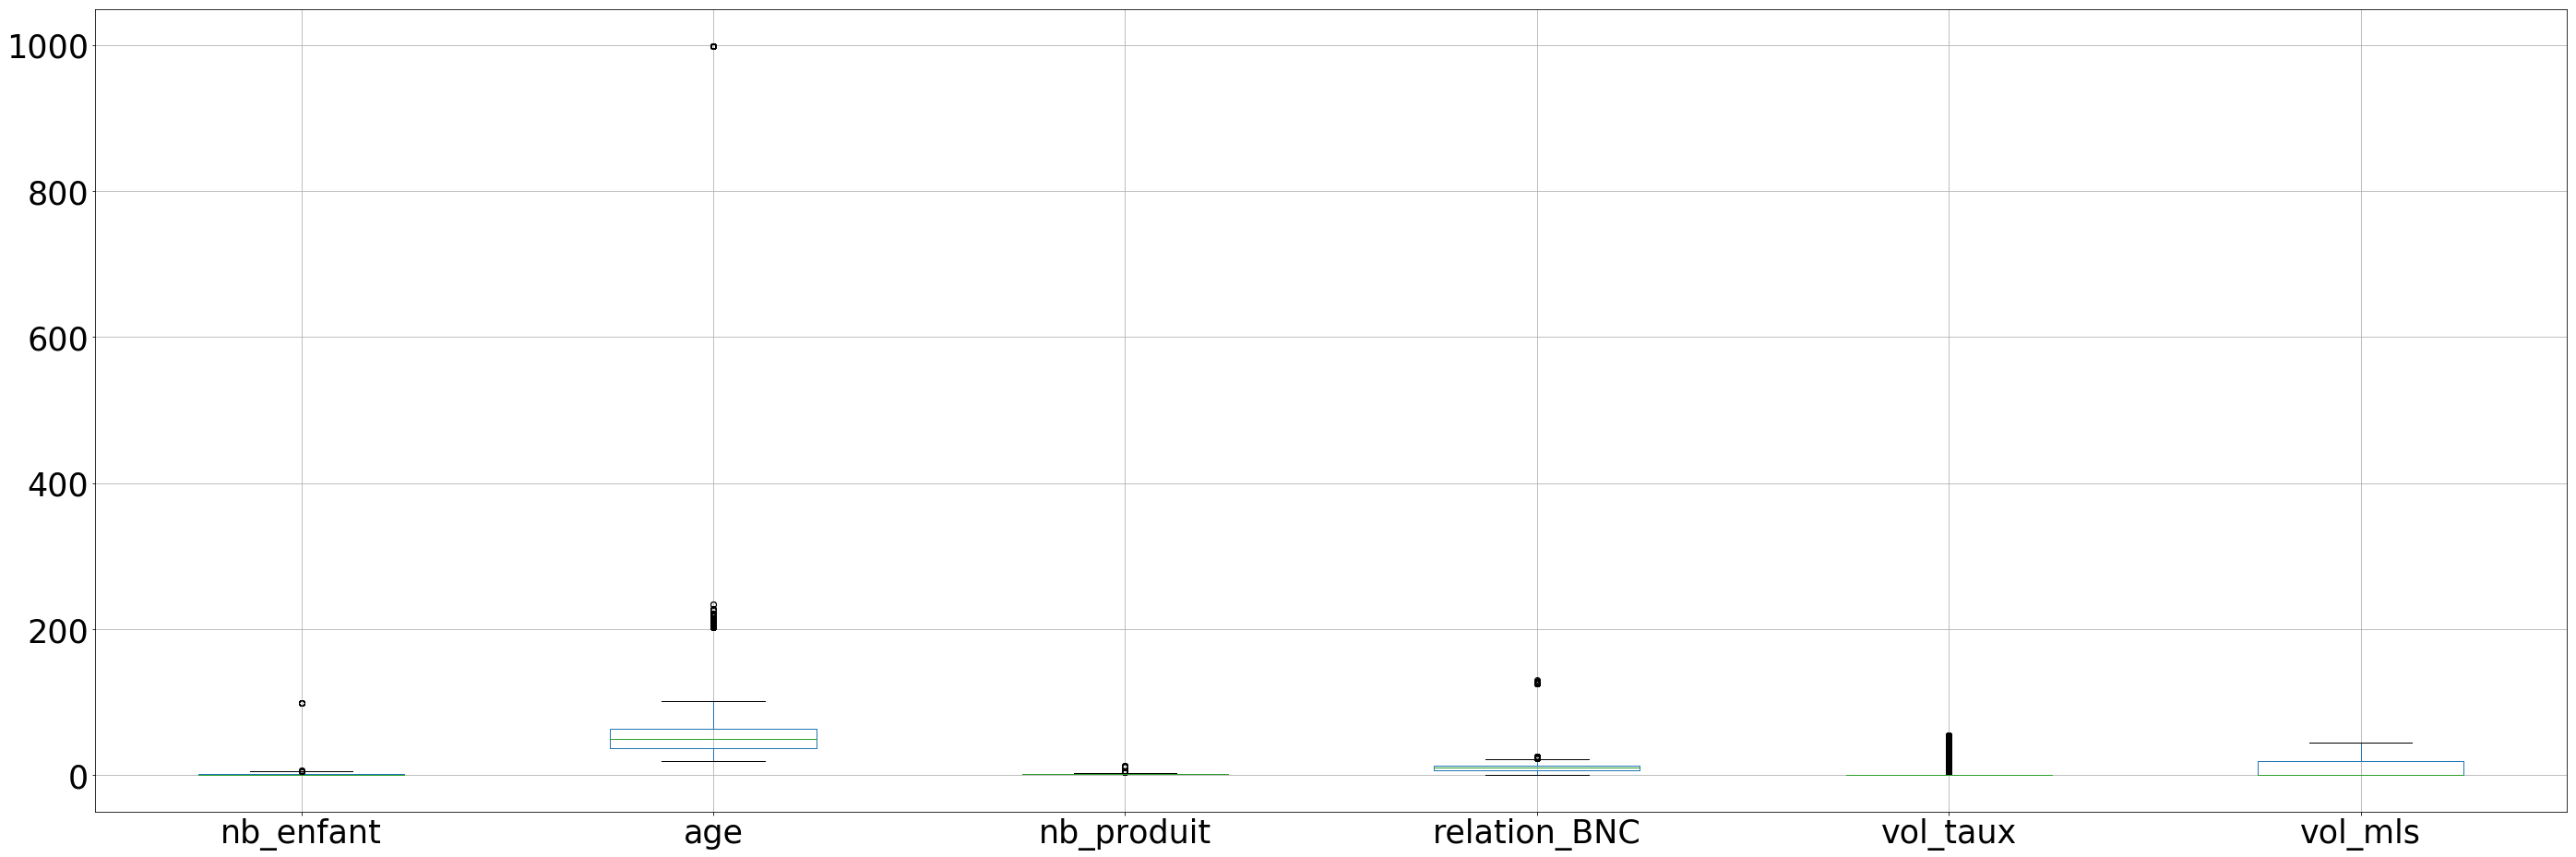

In [204]:
master_prep3.boxplot(fontsize = 35, figsize=(48, 16), column=['nb_enfant','age','nb_produit','relation_BNC','vol_taux','vol_mls'])
plt.show()

In [205]:
# il y a circa 300 lignes avec un age 200+ qui est une quantite trop elevee a supprimer
master_prep3.groupby('age')\
            .size() \
            .reset_index(name='count') \
            .sort_values(['age'], ascending = False) \
            .head()

,age,count
95,999,283
94,234,2
93,228,2
92,226,1
91,225,1


In [206]:
#admettons que l'age jusqu'a 101 est raisonable. Le suivant c'est 200+ 
master_prep3.loc[master_prep3['age'] > 200, 'age'] = np.nan

Apres avoir eliminé les cas aberrants d'age, le cas aberrant de nb_enfant est bien visible

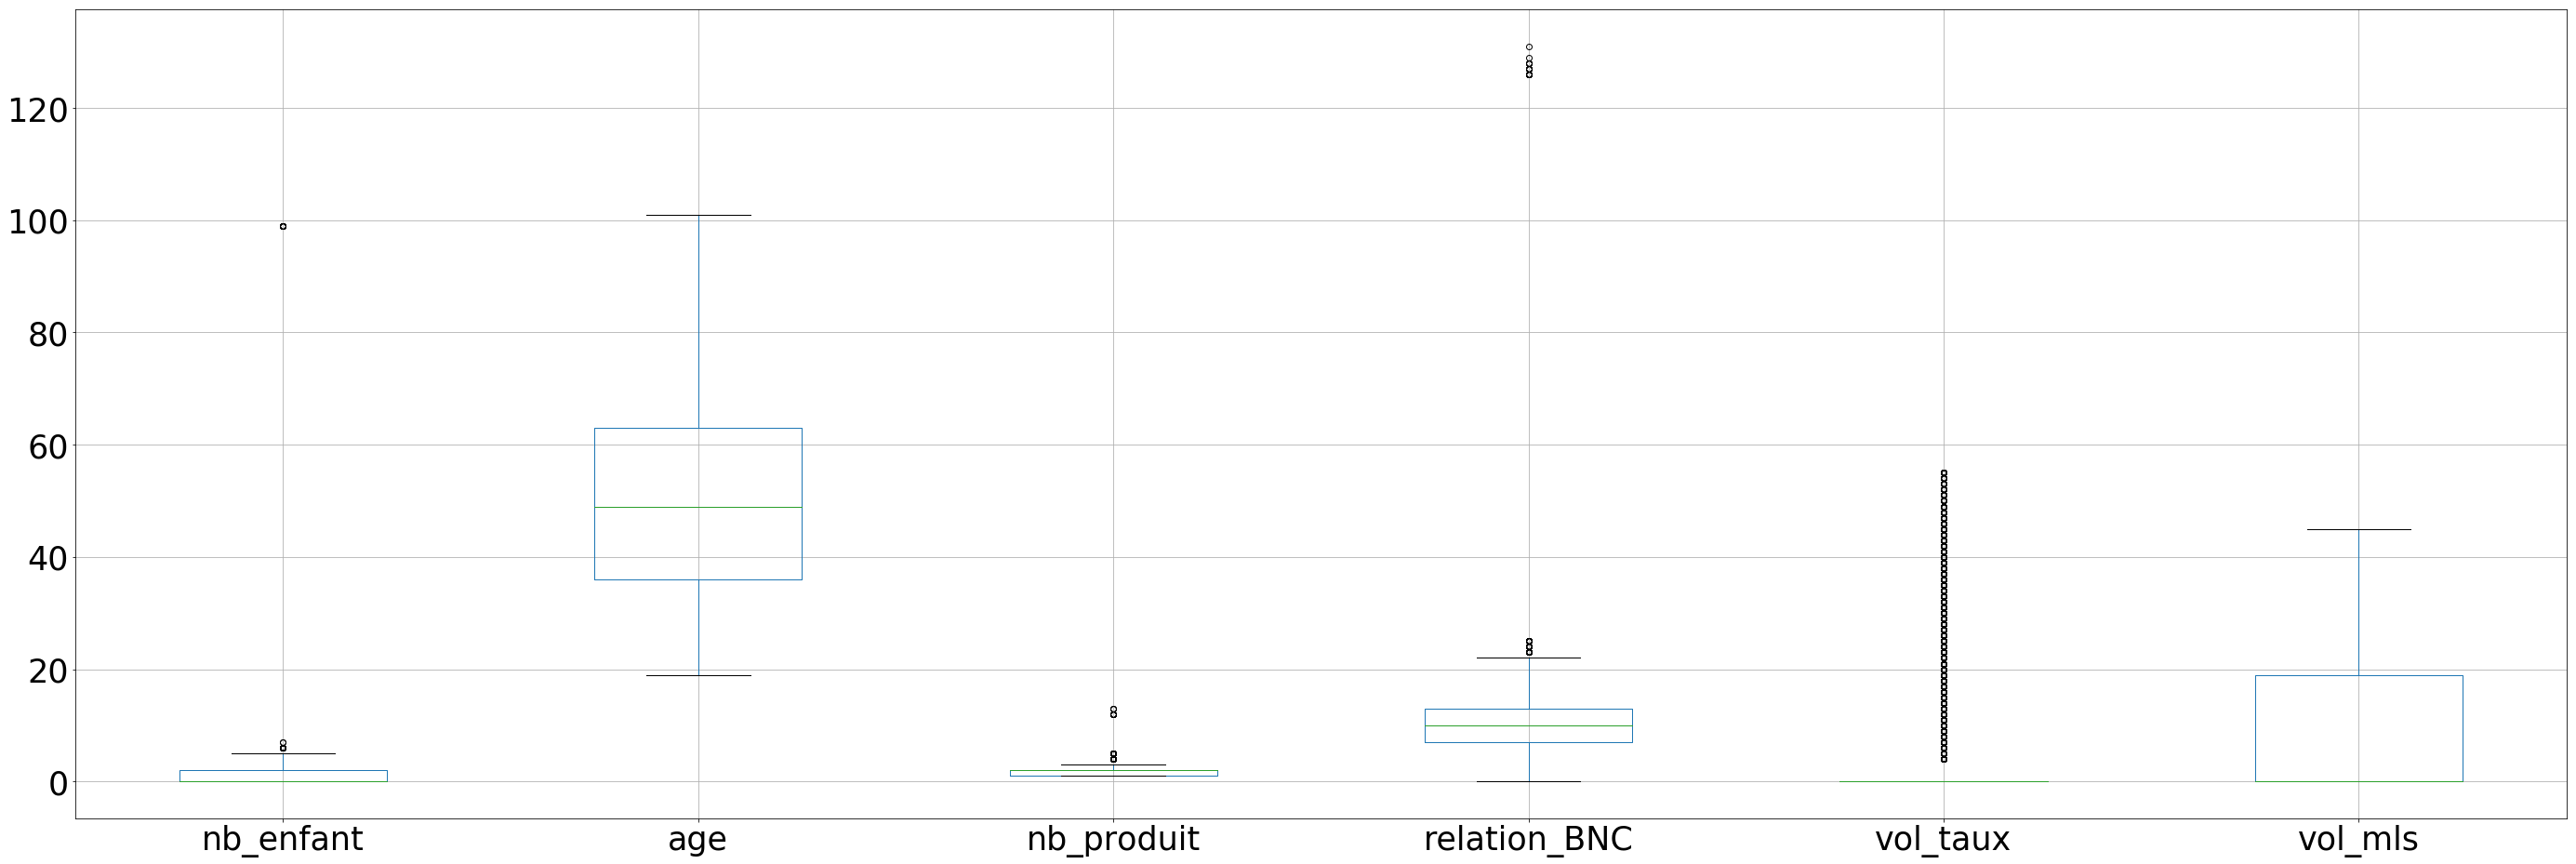

In [207]:
master_prep3.boxplot(fontsize = 35, figsize=(48, 16), column=['nb_enfant','age','nb_produit','relation_BNC','vol_taux','vol_mls'])
plt.show()

Il y a 11 clients avec 99 enfants. Meme si 11 lignes n'est pas forcement une grande quantite, 2 parmis ceux-ci ont PH = 1 
Comme le nombre des lignes avec PH = 1 est limite je préfère de les garder. Je supprime seulement la ligne avec 99 enfansts

In [208]:
master_prep3.groupby('nb_enfant')\
            .size() \
            .reset_index(name='count') \
            .sort_values(['nb_enfant'], ascending = False) \
            .head()

,nb_enfant,count
8,99,11
7,7,2
6,6,133
5,5,555
4,4,1087


In [209]:
master_prep3.loc[master_prep3['nb_enfant'] > 90, 'nb_enfant'] = np.nan

Je vois que certaines lignes ont des valeurs trop élevées de relation_BNC 

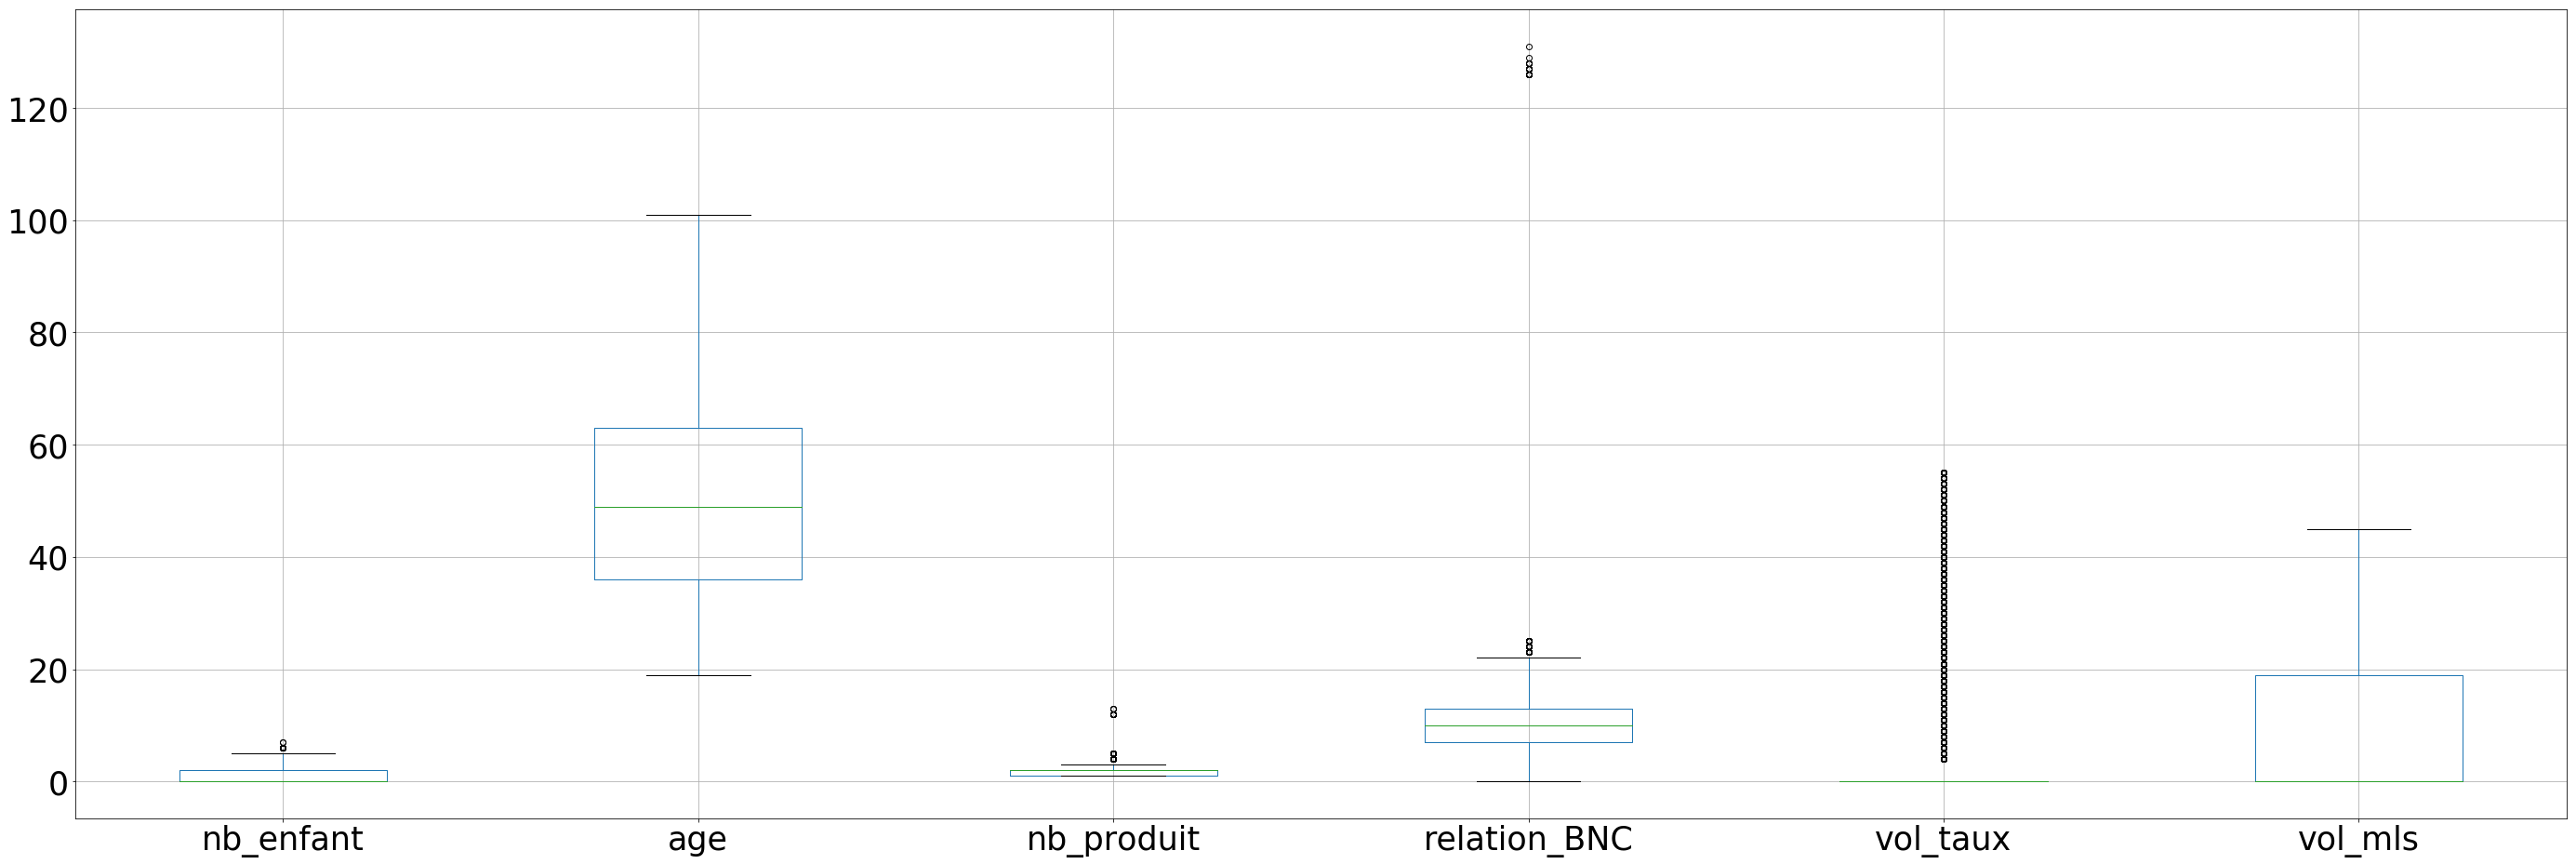

In [210]:
master_prep3.boxplot(fontsize = 35, figsize=(48, 16), column=['nb_enfant','age','nb_produit','relation_BNC','vol_taux','vol_mls'])
plt.show()

In [211]:
master_prep3.groupby('relation_BNC')\
            .size() \
            .reset_index(name='count') \
            .sort_values(['relation_BNC'], ascending = False) \
            .head(10)

,relation_BNC,count
30,131.0,1
29,129.0,1
28,128.0,4
27,127.0,6
26,126.0,10
25,25.0,19
24,24.0,36
23,23.0,44
22,22.0,101
21,21.0,125


Pourtant, un client ne pourrait pas être présent pendant plus de 100ans sauf s'il s'agit d'une entreprise. Néanmoins, quand je trouves des comptes individuel d'une relation de 100+ ans. Si jamais la colonne compte_commercial est erronée, je vérifie les revenus aussi mais je les trouve aux niveaux d'un revenu régulier.

Finalement je supprime les lignes avec une valuer superieur à 100 pour relation_BNC

In [212]:
master_prep3[['compte_commercial','PH','revenu','revenu_foyer']].loc[master_prep3['relation_BNC'] > 100]

,compte_commercial,PH,revenu,revenu_foyer
CLIENT_ID,,,,
2477,0.0,1.0,44000,273000
158157,0.0,0.0,75000,75000
426586,0.0,0.0,56000,56000
508096,0.0,0.0,83000,98000
517163,0.0,0.0,32000,32000
530487,0.0,0.0,72000,72000
532056,1.0,0.0,123000,237000
671733,0.0,0.0,47000,50000
765964,0.0,0.0,73000,73000


In [213]:
master_prep3 = master_prep3.loc[master_prep3['relation_BNC'] < 90]

Je remplace les valeurs nulles dans les colonnes de volumes par 0.Comme il n'y a aucune ligne avec la valuer 0, c'est raisonable

In [214]:
master_prep3[['vol_MC','vol_epargne','vol_transaction', 'vol_financement']] = master_prep3[['vol_MC','vol_epargne','vol_transaction','vol_financement']].fillna(value=0)

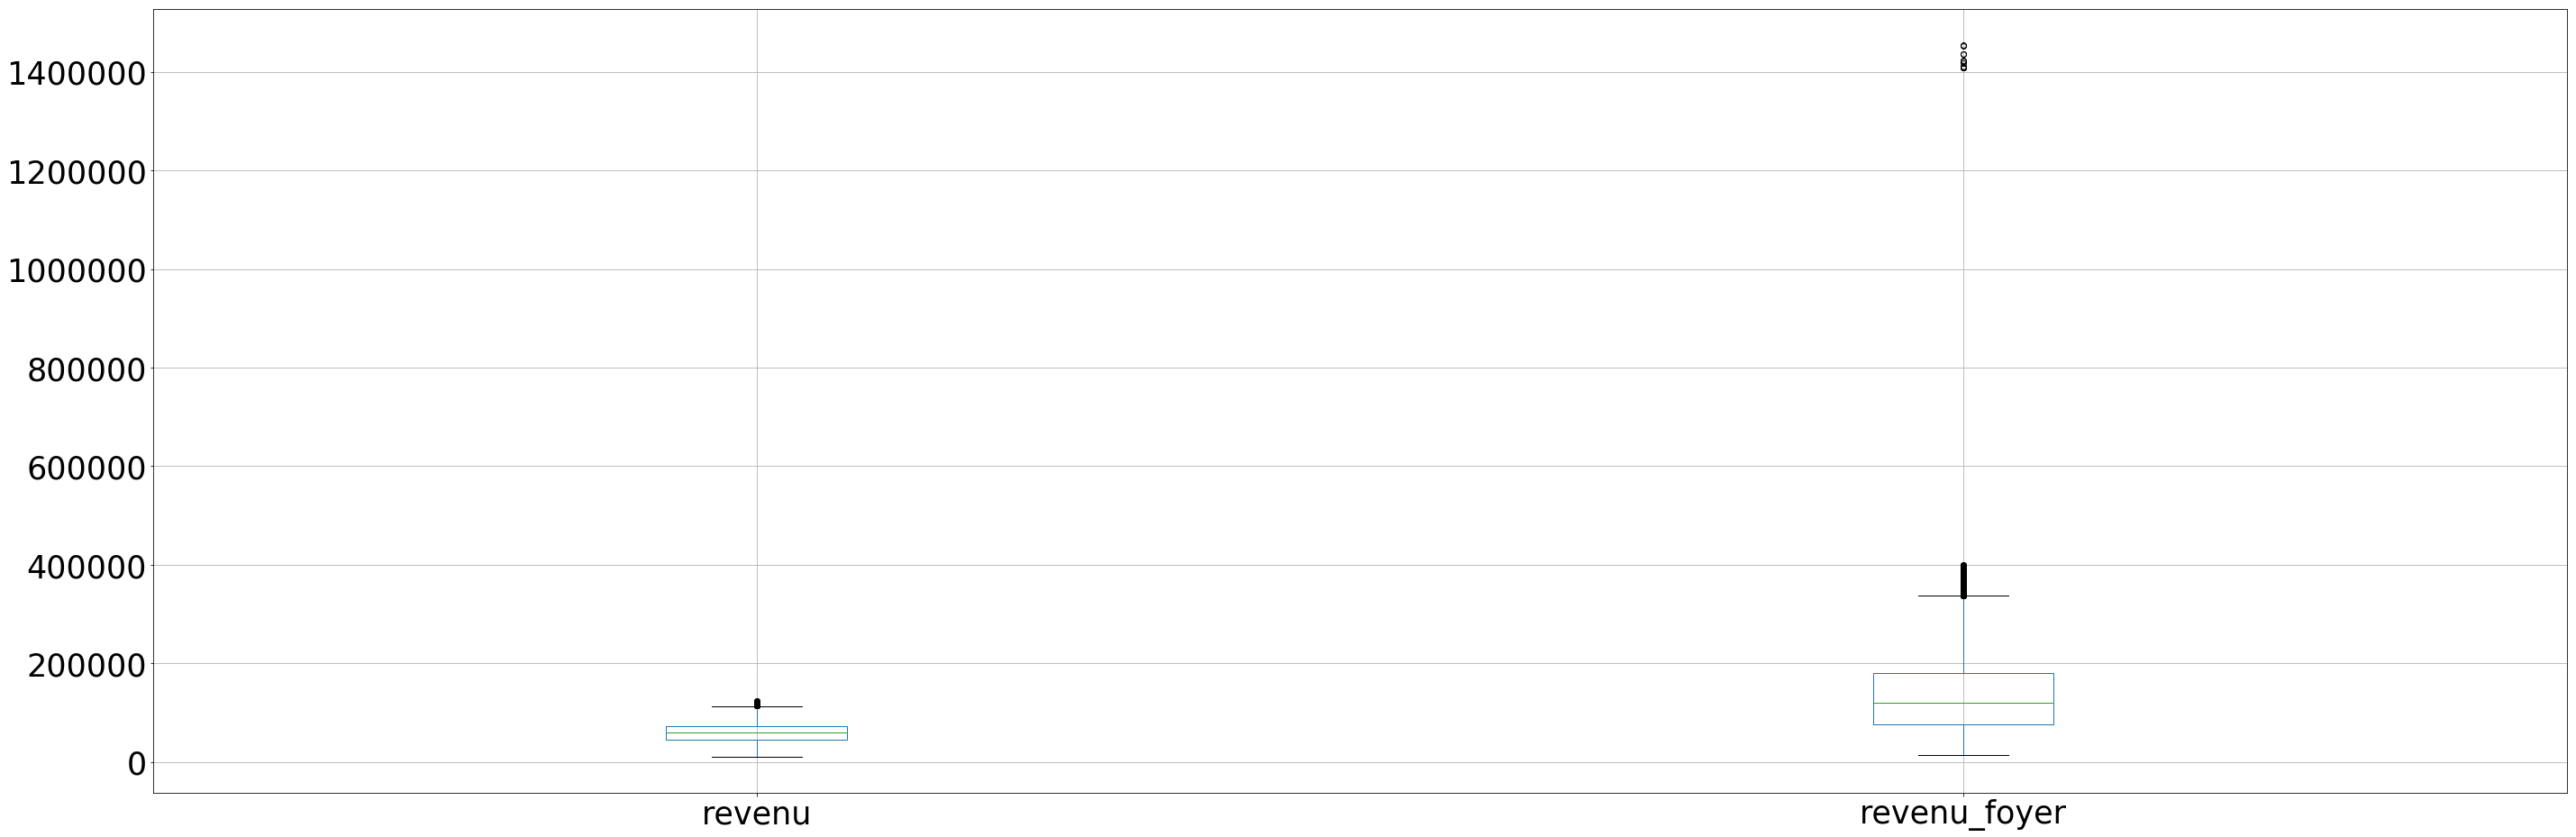

In [215]:
master_prep3.boxplot(fontsize = 35, figsize=(48, 16), column=['revenu','revenu_foyer'])
plt.show()

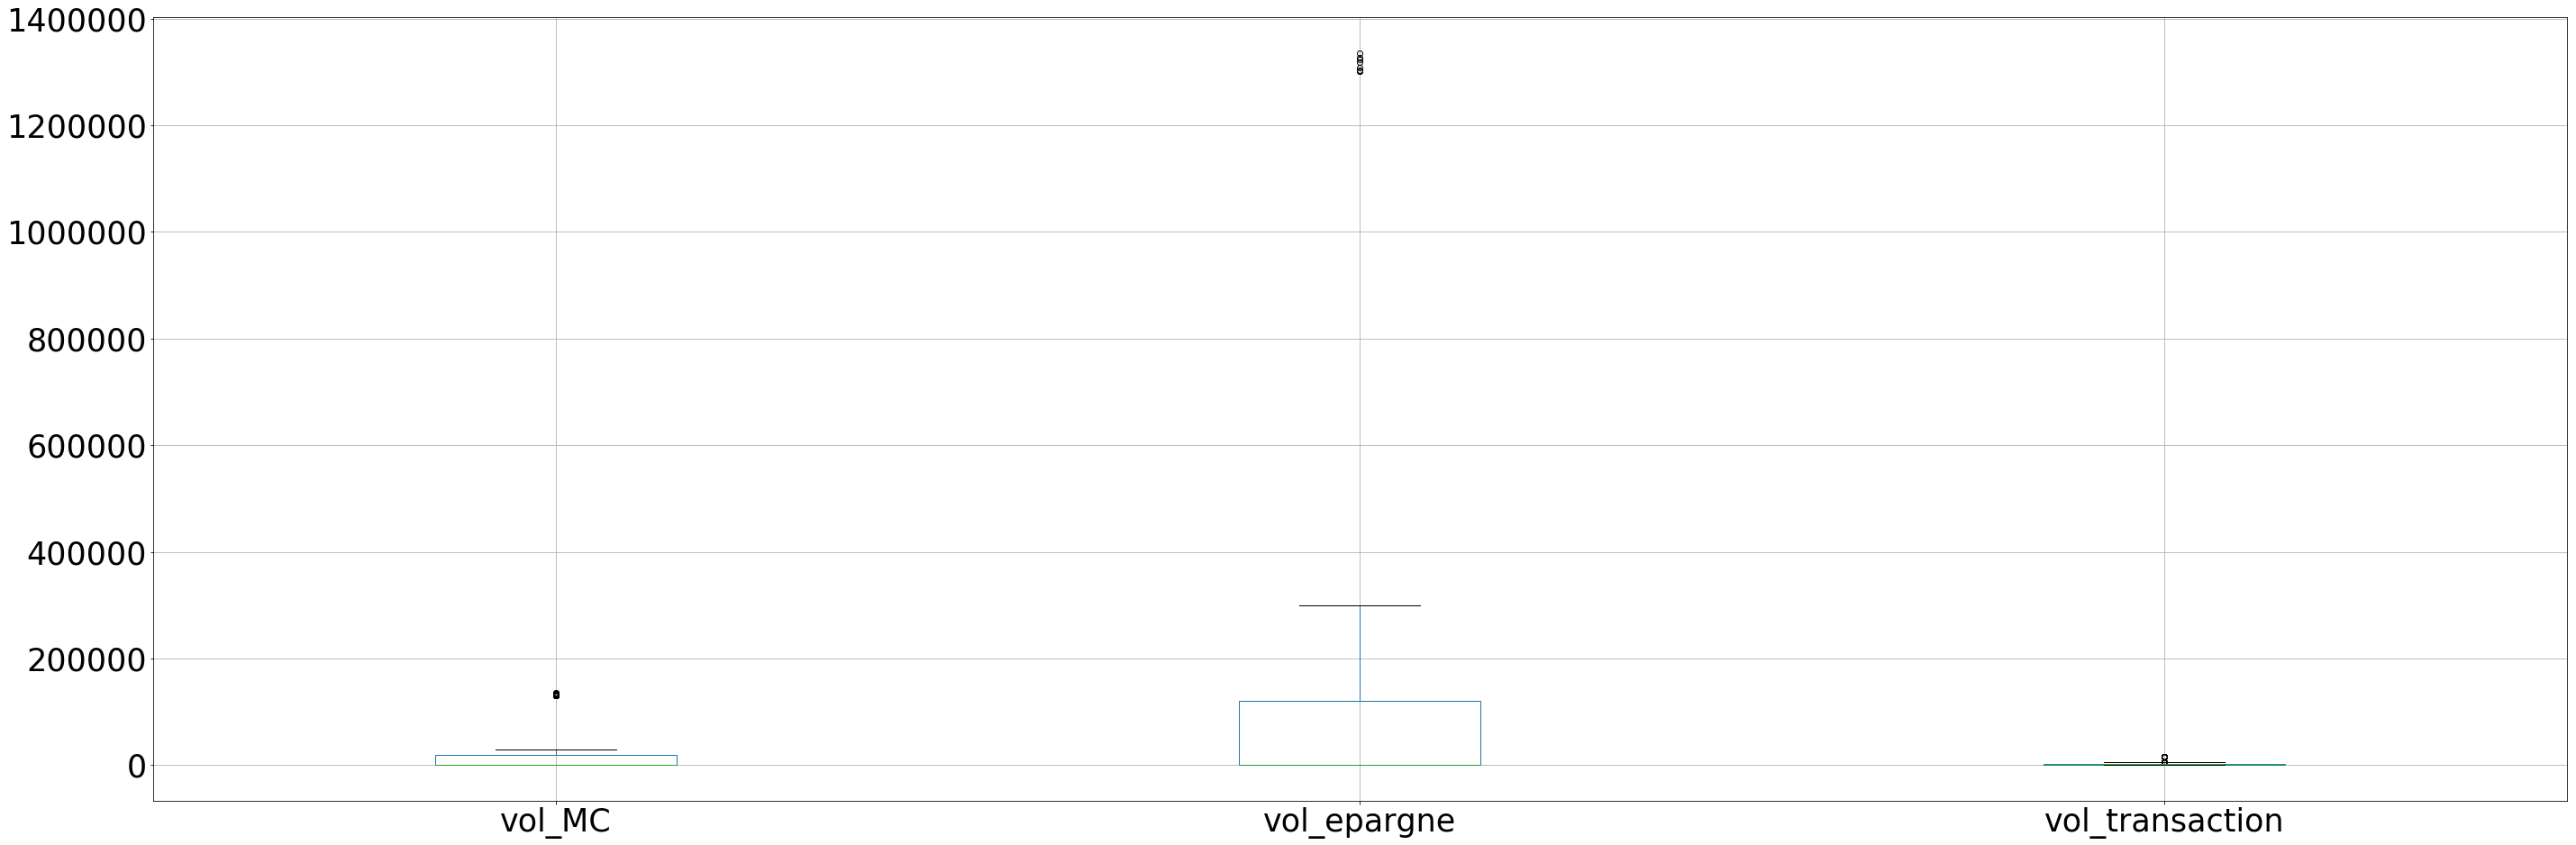

In [216]:
master_prep3.boxplot(fontsize = 35, figsize=(48, 16), column=['vol_MC','vol_epargne', 'vol_transaction'])
plt.show()

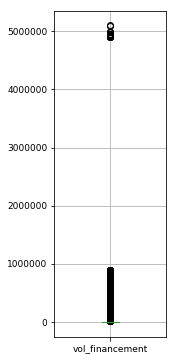

In [217]:
master_prep3.boxplot(fontsize = 9, figsize=(2, 6), column=['vol_financement'])
plt.show()

Les boxplots ci-dessus m'ont incité à regarder les histogrammes des revenus et volumes.
Les revenus sont plutôt raisonable 
Les histogrammes pour les volumes sont néanmoins ouvertes à la discussion pour supprimer les lignes extrèmes.
Faute d'une preuve ou une explication d'un expert, je préfère de les garder 

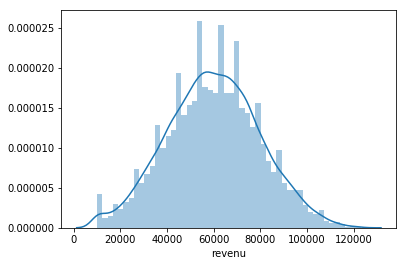

In [218]:
sns.distplot(master_prep3['revenu'])
plt.show()

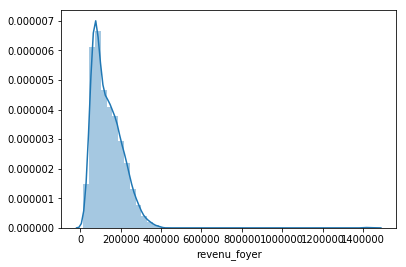

In [219]:
sns.distplot(master_prep3['revenu_foyer'])
plt.show()

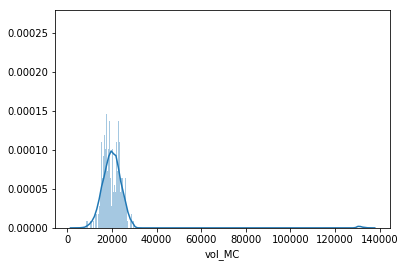

In [220]:
sns.distplot(master_prep3['vol_MC'][master_prep3['vol_MC'] > 0], bins = 10000)
plt.show()

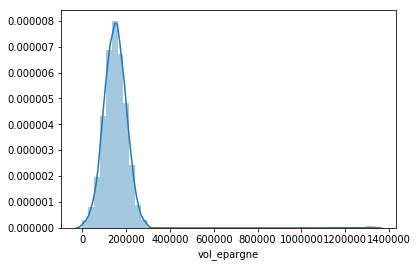

In [221]:
sns.distplot(master_prep3['vol_epargne'][master_prep3['vol_epargne'] > 0])
plt.show()

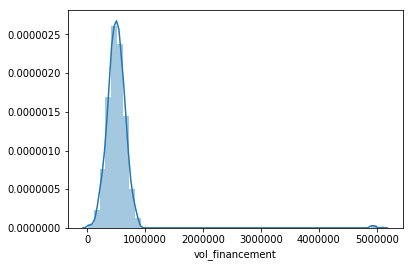

In [222]:
sns.distplot(master_prep3['vol_financement'][master_prep3['vol_financement'] > 0])
plt.show()

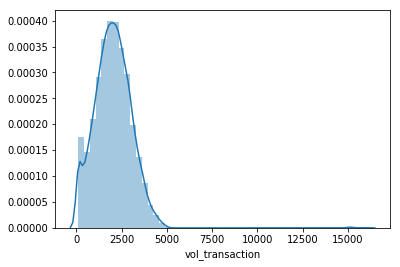

In [223]:
sns.distplot(master_prep3['vol_transaction'][master_prep3['vol_transaction'] > 0])
plt.show()

## Transformer les Variables Qualitatives

Les variables profession et ville sont à transformer a travers one-hot encoding. Notez que l'education est une variable ordinale ou les chiffres représentant l'education sont proportionells au niveau d'education

In [224]:
one_hot_profession = pd.get_dummies(master_prep3['profession'])
master_prep3 = master_prep3.drop('profession',axis = 1)
master_prep3 = master_prep3.join(one_hot_profession)
master_prep3.rename(columns={1: "professionel", 2: "manager", 3: "col_bleu", 4: "col_blanc", 5: "retraite", 6: "chomeur"}, inplace = True)

In [225]:
one_hot_ville = pd.get_dummies(master_prep3['ville'])
master_prep3 = master_prep3.drop('ville',axis = 1)
master_prep3 = master_prep3.join(one_hot_ville)
master_prep3.rename(columns={1: "outaouais", 2: "estrie", 3: "rive_sud", 4: "rive_nord", 5: "quebec", 6: "mtl"}, inplace = True)
master_prep3.head(2)

,MOIS_demo,homme,courriel,Langue_Francais,naissance,logement,nb_enfant,education,age,revenu,...,col_bleu,col_blanc,retraite,chomeur,outaouais,estrie,rive_sud,rive_nord,quebec,mtl
CLIENT_ID,,,,,,,,,,,,,,,,,,,,,
276,2018-08-31,1,1,1,1,1,4.0,1,36.0,71000,...,0,0,0,0,0,0,0,0,1,0
335,2017-10-31,0,1,0,0,0,0.0,3,53.0,67000,...,1,0,0,0,1,0,0,0,0,0


Pour chaque ligne, seulement le dernier jour du mois est fournit qui devrait être symbolique.
Il n'est ainsi pas nécessaire de créer une variable en fonction du jour du mois.
Par contre on pourrait observer une tendance saisonnière. Je pense que les achats d'immeuble augmentent en été quand il est plus convenable pour démenager. Je récupère ainsi les périodes en trimestres. 

In [226]:
master_prep3['q'] = pd.DatetimeIndex(master_prep3['MOIS_demo']).quarter

In [227]:
one_hot_quarter = pd.get_dummies(master_prep3['q'])
master_prep3 = master_prep3.drop('q',axis = 1)
master_prep3 = master_prep3.join(one_hot_quarter)
master_prep3.rename(columns={1: "q1", 2: "q2", 3: "q3", 4: "q4"}, inplace = True)

J'ai eu l'impression que la qualité de données n'est pas parfaite. Malgré les vérifications que j'ai faites, on pourrait toujours avoir des observations aberrantes. 
Par coséquent, j'utilise la médiane au lieu de la moyenne pour remplir les valeurs manquantes dans les 2 colonnes: age, nb_enfant

In [228]:
master_prep3.fillna(master_prep3.median(), inplace = True)

Finalement, continuons avec un dataframe frais:

In [229]:
df = master_prep3

## Analyser les Relations Visuellement
La quantité limitée des cas positifs (PH = 1) complique l'interprétation des graphiques. Néanmoins il est possible d'observer une différence dans hypothèque, en fonction du revenu foyer contrairement au revenu indicviduel

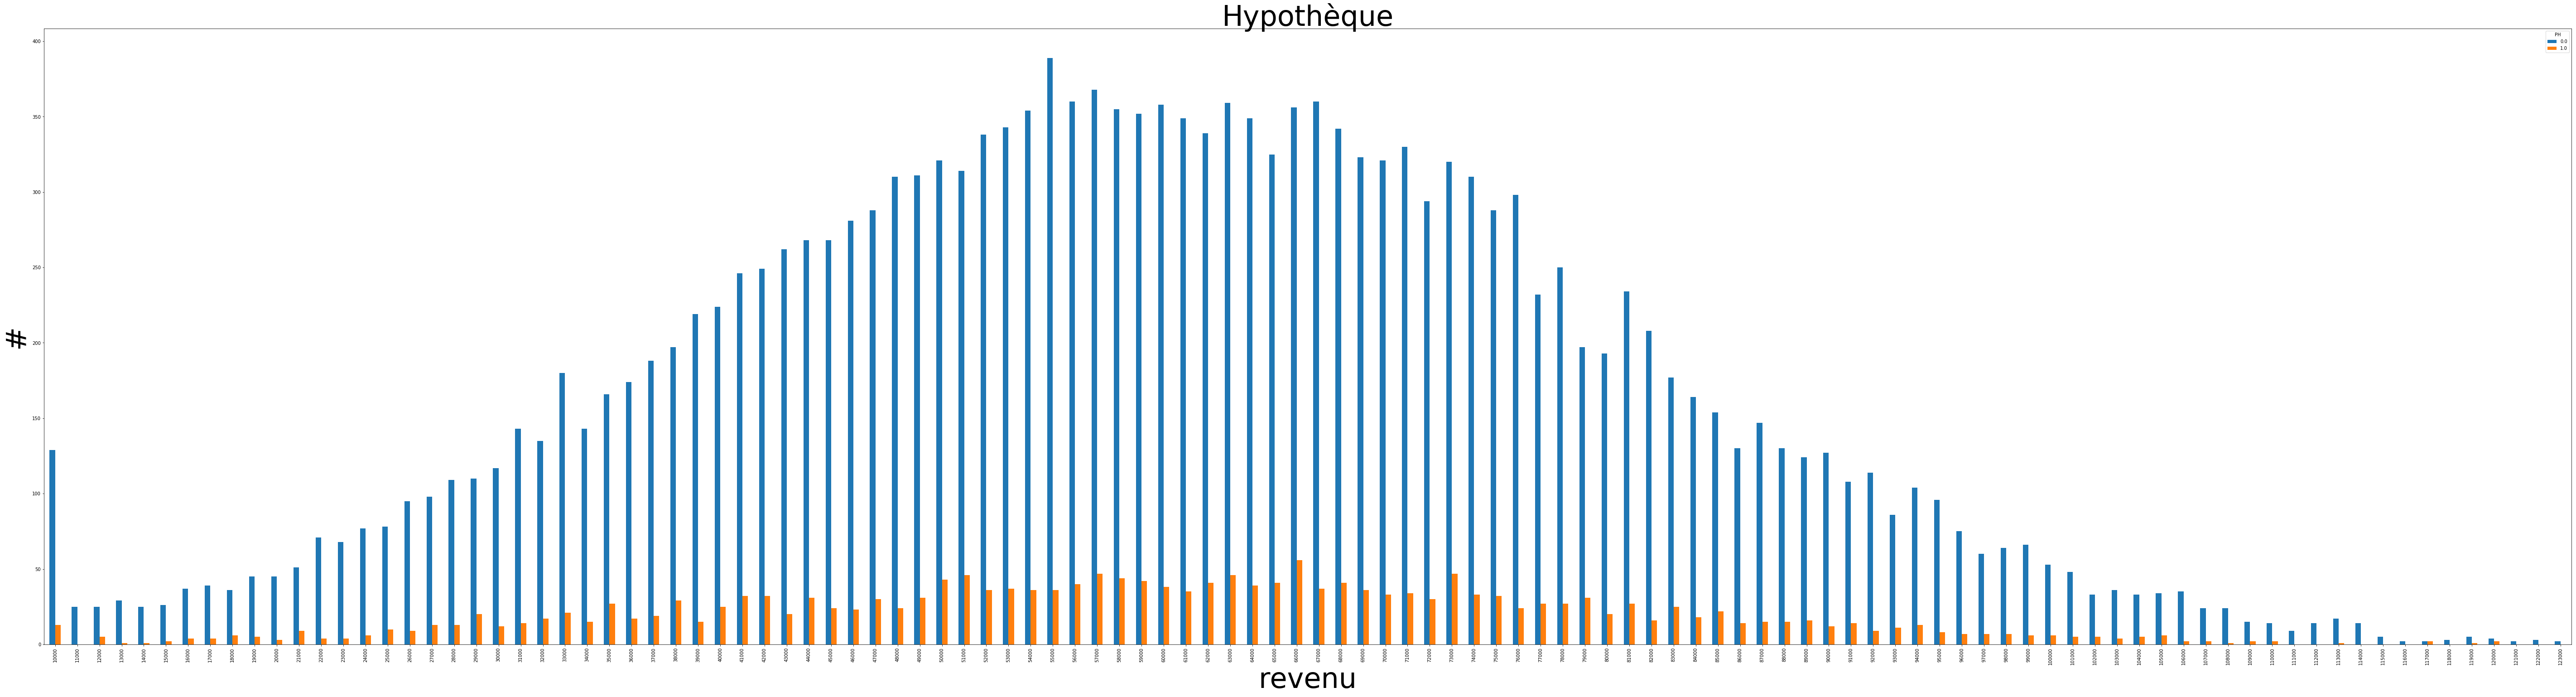

In [230]:
pd.crosstab(df['revenu'], df['PH']).plot(kind='bar', figsize=(100, 25))
plt.title('Hypothèque',fontsize = 62, )
plt.xlabel('revenu', fontsize = 62)
plt.ylabel('#', fontsize = 62, )
plt.show()

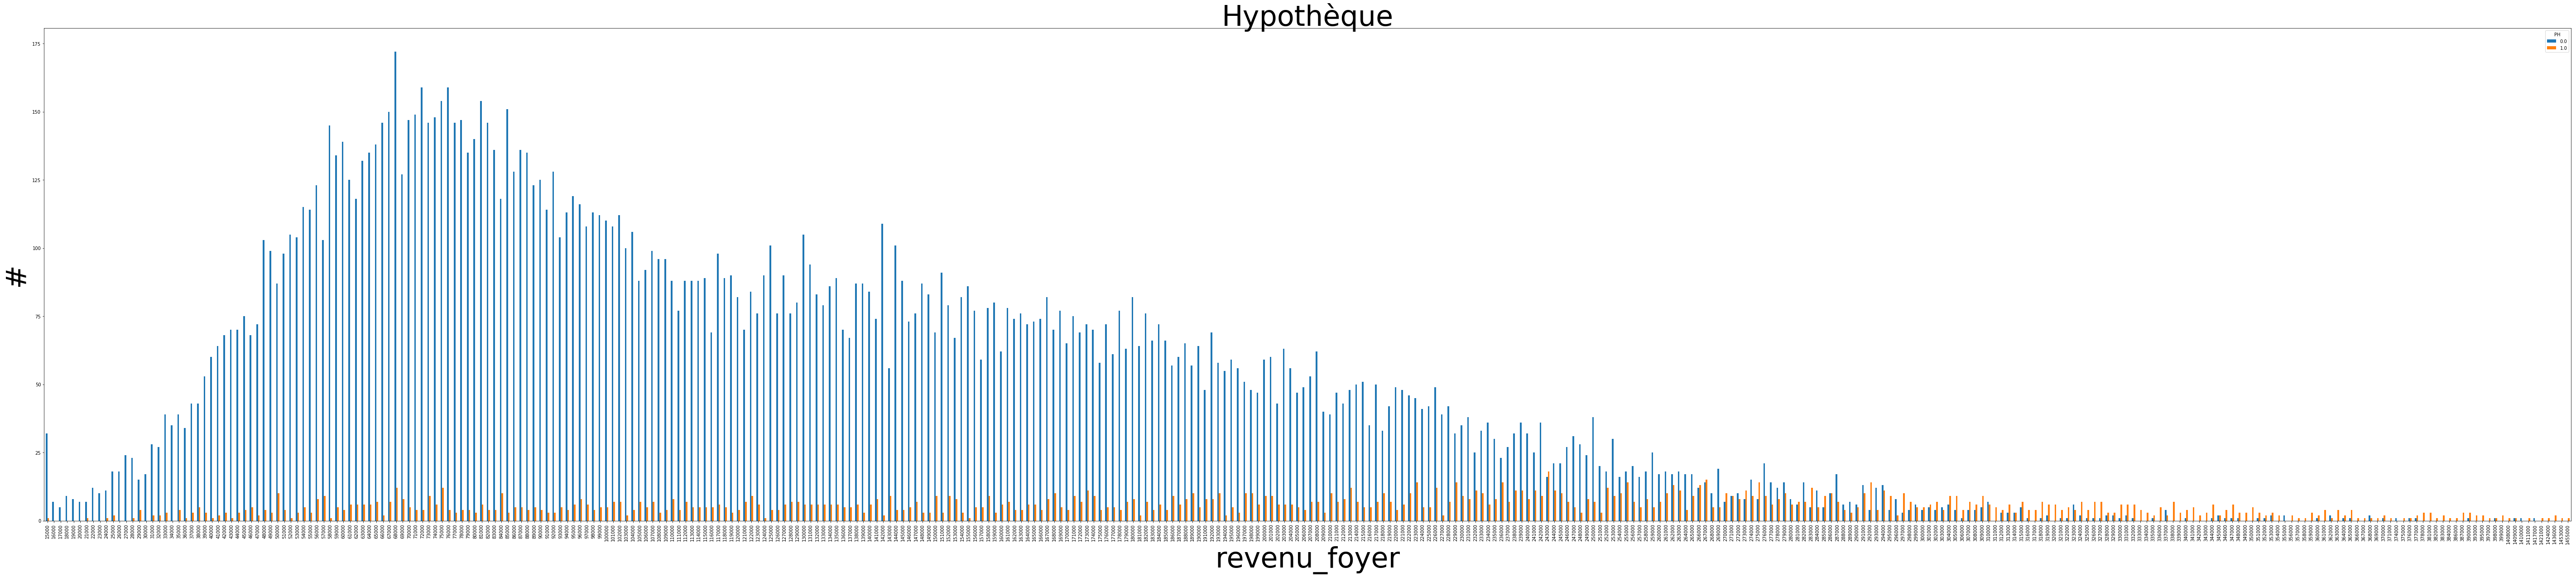

In [231]:
pd.crosstab(df['revenu_foyer'], df['PH']).plot(kind='bar', figsize=(100, 20))
plt.title('Hypothèque',fontsize = 62, )
plt.xlabel('revenu_foyer',fontsize = 62, )
plt.ylabel('#',fontsize = 62, )
plt.show()

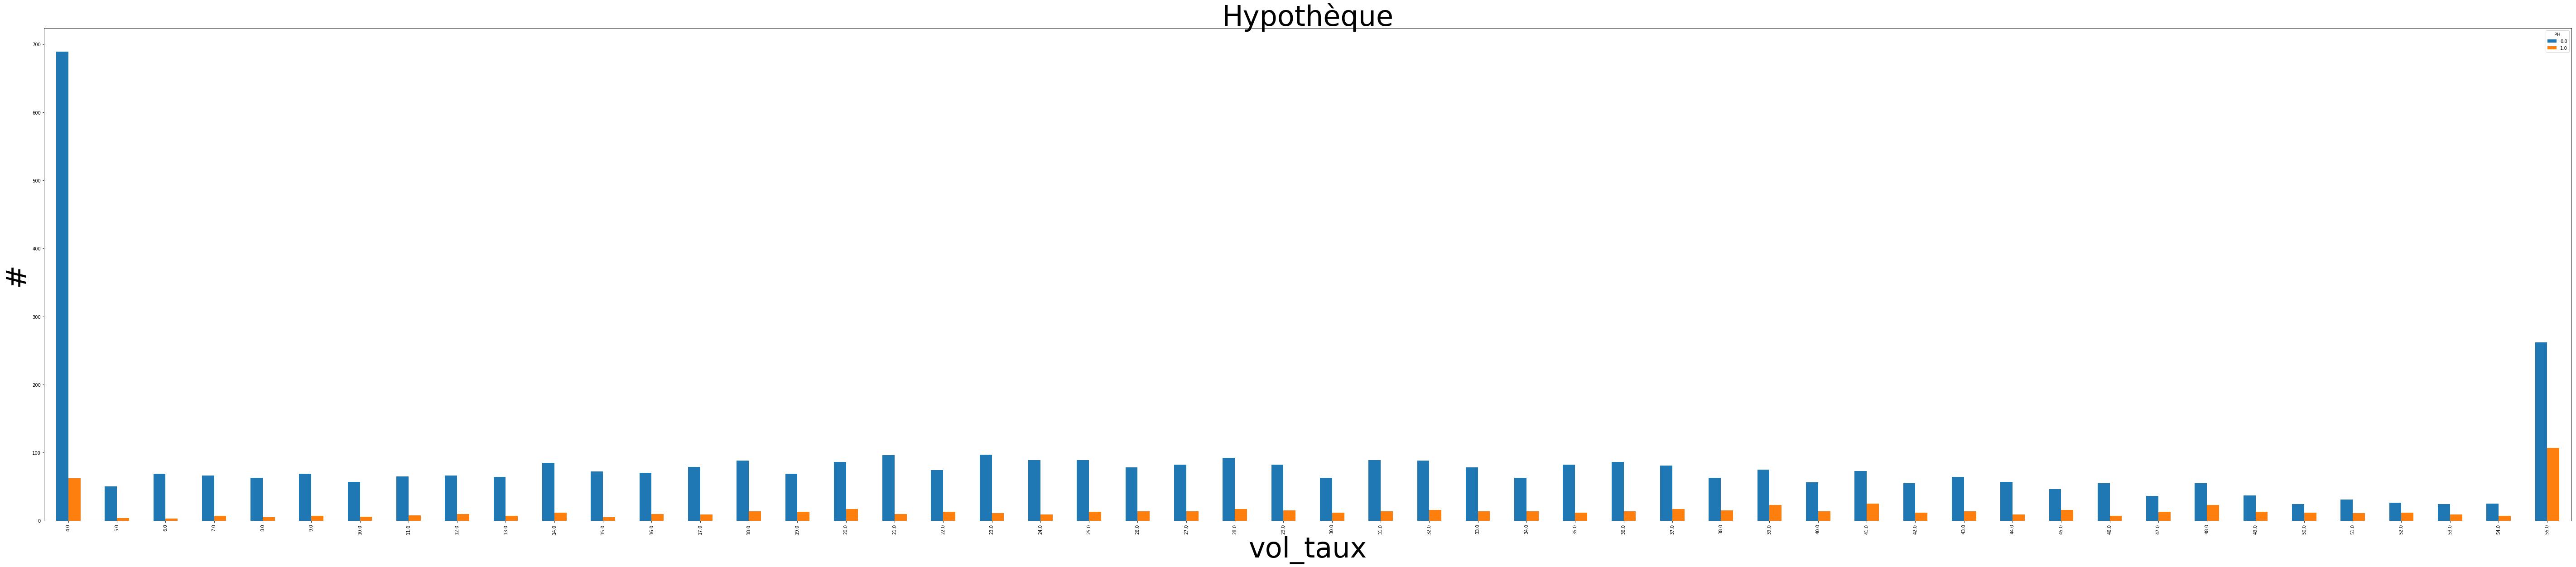

In [232]:
pd.crosstab(df['vol_taux'][df['vol_taux'] > 0], df['PH']).plot(kind='bar', figsize=(100, 20))
plt.title('Hypothèque',fontsize = 62, )
plt.xlabel('vol_taux',fontsize = 62, )
plt.ylabel('#',fontsize = 62, )
plt.show()

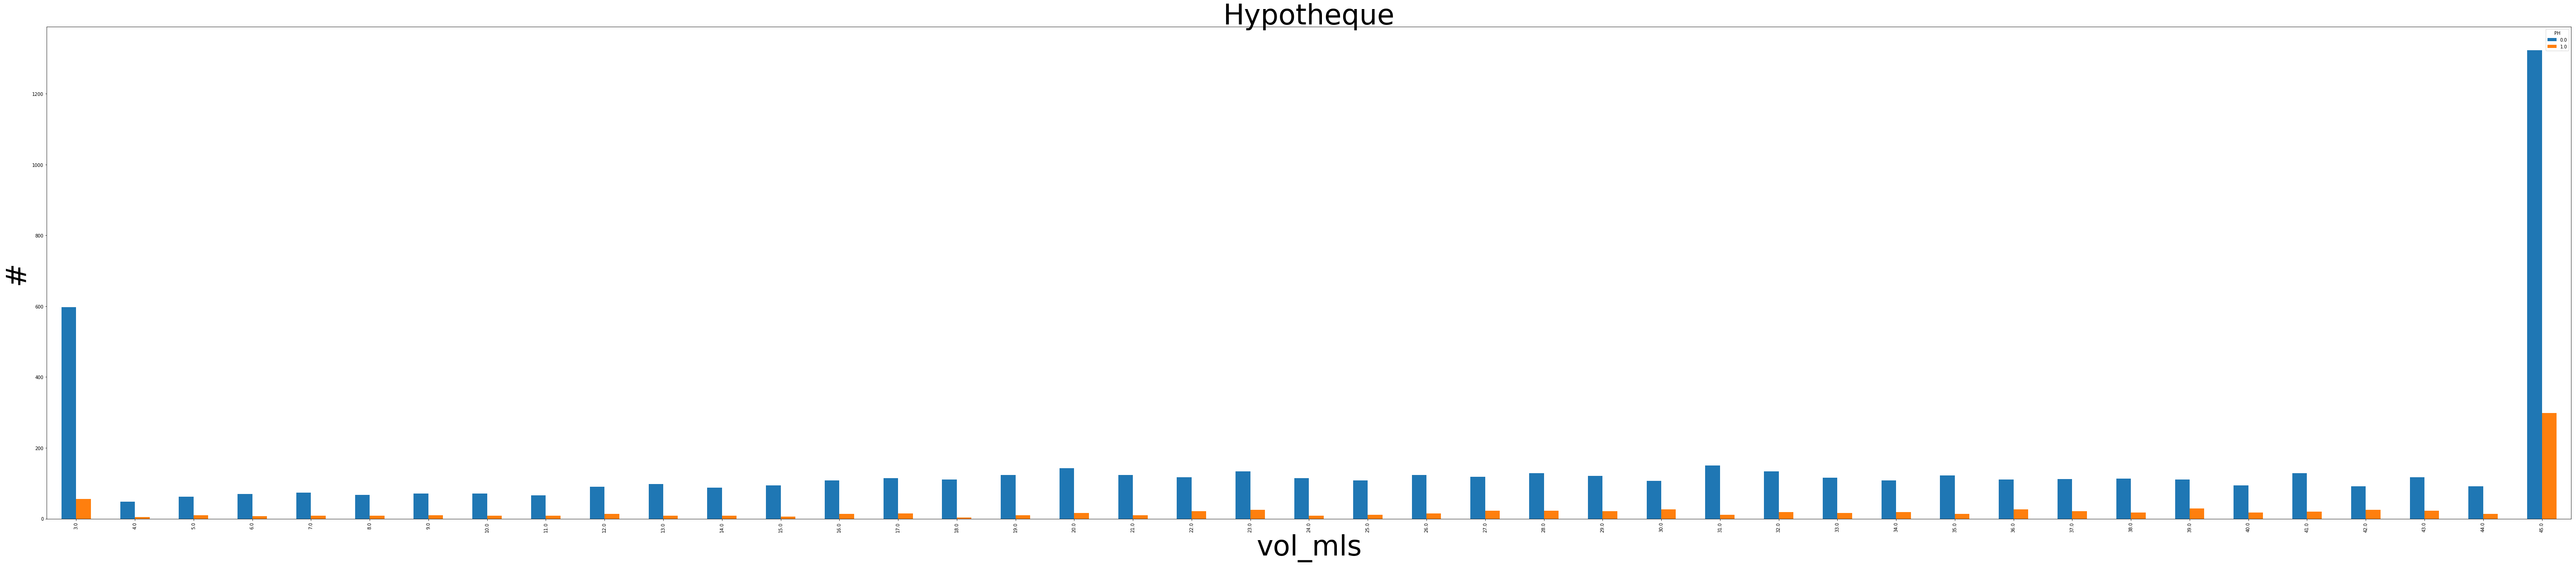

In [233]:
pd.crosstab(df['vol_mls'][df['vol_mls'] > 0], df['PH']).plot(kind='bar', figsize=(100, 20))
plt.title('Hypotheque',fontsize = 62, )
plt.xlabel('vol_mls',fontsize = 62, )
plt.ylabel('#',fontsize = 62, )
plt.show()

## Choisir les composants
Je côntrole le niveau de corrélation parmis les variables qui sont censées d'être interconnectées d'après les explications fournies. J'observe pas une association remarquable. J'évite ainsi une méthode de réduction de dimensionnalité. Appliquer une telle méthode nécessite également une bonne connaissance dans le domaine afin de pouvoir observer les dimensions obtenue.

In [234]:
df[['sphere_epargne', 'sphere_financement', 'sphere_transaction']].corr()

,sphere_epargne,sphere_financement,sphere_transaction
sphere_epargne,1.000000,-0.005312,-0.010110
sphere_financement,-0.005312,1.000000,0.006966
sphere_transaction,-0.010110,0.006966,1.000000


In [235]:
df[['vol_MC', 'vol_epargne','vol_financement', 'vol_transaction']].corr()

,vol_MC,vol_epargne,vol_financement,vol_transaction
vol_MC,1.000000,0.002477,-0.005468,-0.004410
vol_epargne,0.002477,1.000000,-0.004339,-0.007148
vol_financement,-0.005468,-0.004339,1.000000,-0.005566
vol_transaction,-0.004410,-0.007148,-0.005566,1.000000


#### Diviser des données pour apprentissage
Je prends les catégories ci-dessous comme des catégories de référence et je les exclu:
1. montréal: 1 si le client habite à MTL
2. chomeur: 1 si le client est chômeur
3. q1: 1 si la période en question est le 1er trimestre

In [236]:
X = df[['age', 'nb_enfant', 'homme', 'courriel', 'Langue_Francais', 'naissance',
       'logement', 'education', 'revenu', 'revenu_foyer',
       'pret_anterieur', 'compte_commercial', 'carte_MC', 'NSF', 'PH_autre_FI',
       'sphere_epargne', 'sphere_financement', 'sphere_transaction',
       'nb_produit', 'relation_BNC', 'vol_MC', 'vol_epargne',
       'vol_financement', 'vol_transaction', 'TEF', 
        'mono_produit',
       'taux', 'GDP', 'web_taux', 'web_mls', 'vol_taux', 'vol_mls',
       'professionel', 'manager', 'col_bleu', 'col_blanc', 'retraite',
       'outaouais', 'estrie', 'rive_sud', 'rive_nord', 'quebec',
       'q2', 'q3', 'q4']]
y = df['PH']
print(X.shape, y.shape)

(20426, 45) (20426,)


In [237]:
# Je divise les données en 2: training et test
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=1)

#### Régression Lasso
Comme le nombre des observations positives en PH sont limitées, il y a un risque d'overfit.
Sélectionner les composants pertinents et éliminant le reste pourrait servir à le diminuer. Pour cet objectif, j'utilise Lasso:

In [238]:
from sklearn.linear_model import LassoCV, Lasso
from sklearn.metrics import mean_squared_error
lasso = Lasso(max_iter = 10000, normalize = True)

lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv.fit(X_train, y_train)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
mean_squared_error(y_test, lasso.predict(X_test))

0.07525070105707897

In [239]:
pd.Series(lasso.coef_, index=X.columns)

age                   9.941827e-04
nb_enfant             2.106778e-03
homme                 8.041699e-03
courriel              2.627232e-04
Langue_Francais       4.493932e-03
naissance             7.868573e-02
logement              5.896336e-02
education            -2.420136e-05
revenu               -6.012670e-08
revenu_foyer          1.342044e-06
pret_anterieur       -6.474446e-03
compte_commercial     0.000000e+00
carte_MC             -0.000000e+00
NSF                  -3.999063e-02
PH_autre_FI           3.147650e-03
sphere_epargne        0.000000e+00
sphere_financement    1.307202e-02
sphere_transaction    1.322863e-02
nb_produit            8.209996e-03
relation_BNC          3.939703e-03
vol_MC               -4.451406e-07
vol_epargne           0.000000e+00
vol_financement       2.156575e-08
vol_transaction       0.000000e+00
TEF                   3.739254e-02
mono_produit          1.419323e-02
taux                 -1.448157e-02
GDP                   0.000000e+00
web_taux            

#### Régression Logistique
J'élimine les composants qui se révèlent d'être no-significatifs d'après Lasso et je continue avec la construction de mon modèle.
Comme indiqué plus haut, je pourrais toujours avoir des observations aberrantes.
* SVM est mieux adapté pour ce type de situations avec son loss function qui diverge plus rapidement par rapport au celui de la régression logistique. 
* Néanmoins, le calcul d'un modèle SVM dure plus longtemps. 
* En raison
    * de contraintes de temps est 
    * de son interprétation plus simple,
je construis mon modèle en utilisant la régression logistique

In [240]:
X_train2 = X_train.drop(columns = ['compte_commercial', 'carte_MC', 'sphere_epargne', 'vol_epargne', 
                                   'vol_transaction', 'GDP', 'web_mls', 'col_blanc', 
                                   'retraite', 'estrie', 'q4'])
X_test2 = X_test.drop(columns =  ['compte_commercial', 'carte_MC', 'sphere_epargne', 'vol_epargne', 
                                   'vol_transaction', 'GDP', 'web_mls', 'col_blanc', 
                                   'retraite', 'estrie', 'q4'])

In [241]:
logit_model=sm.Logit(y_train, X_train2)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.233713
         Iterations 8
                          Results: Logit
Model:               Logit            Pseudo R-squared: 0.257      
Dependent Variable:  PH               AIC:              1977.4358  
Date:                2019-04-18 09:37 BIC:              2192.1484  
No. Observations:    4085             Log-Likelihood:   -954.72    
Df Model:            33               LL-Null:          -1284.6    
Df Residuals:        4051             LLR p-value:      1.1939e-117
Converged:           1.0000           Scale:            1.0000     
No. Iterations:      8.0000                                        
-------------------------------------------------------------------
                    Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------
age                 0.0080   0.0035   2.3160 0.0206  0.0012  0.0148
nb_enfant           0.0149   0.0502   0.2

In [242]:
lr = LogisticRegression()
lr.fit(X_train2, y_train)
y_pred = lr.predict(X_test2)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [243]:

accuracy_score(y_test, y_pred)

0.8972523101401383

Malgré le bon niveau d'accuracy, il y a un deséquilibre entre les observations positives et négatives. 
Seulement 10% des données sont associées avec un hypothèque

In [244]:
#sum(y_train): le nombre des observations positives 
# len(y_train): le nombre total des observations 0 / 1
sum(y_train)/len(y_train) 

0.0952264381884945

Le défi avec les données deséquilibrées est de pouvoir identifier une bonne partie des observations positives. Malgré le fait que j'ai essayé de limiter le nombre de composants, il y a un problème d'overfitting. Ceci est illustré par recall: Le modèle est capable d'identifiéer seulement 6% des observations positives:

In [245]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.90      0.99      0.95     14677
         1.0       0.47      0.06      0.11      1664

   micro avg       0.90      0.90      0.90     16341
   macro avg       0.69      0.53      0.53     16341
weighted avg       0.86      0.90      0.86     16341



Parmi différentes méthodes disponibles pour les données deséquilibrées, je préfère SMOTE car, en produisant des observations 'artificielles'...
1. il évite la perte d'information, contrairement à undersampling, 
2. Il évite également plus d'overfit qui pourrait être une consequence d'oversampling
3. Il est facile à interprêter

In [246]:
smt = SMOTE()
X_train2_s, y_train_s = smt.fit_sample(X_train2, y_train)

In [247]:
sum(y_train_s)/len(y_train_s)

0.5

In [248]:
lr_s = LogisticRegression()
lr_s.fit(X_train2_s, y_train_s)
y_pred_s = lr_s.predict(X_test2)

accuracy_score(y_test, y_pred_s)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6670338412581849

Malgré le réduction dans l'accuracy, le niveau de recall est désormais beaucoup plus acceptable. Il est monté de moins de 0.1 à plus de 0.7!

In [249]:
print(classification_report(y_test, y_pred_s))

              precision    recall  f1-score   support

         0.0       0.95      0.66      0.78     14677
         1.0       0.19      0.71      0.30      1664

   micro avg       0.67      0.67      0.67     16341
   macro avg       0.57      0.69      0.54     16341
weighted avg       0.88      0.67      0.73     16341



Finalement, dès progrès sont possibles qui est mieux visualisé à traver la graphique ROC.
d'autres développements devraient viser à rapprocher la ligne bleu vers les bordures à gauche est en haut, afin d'augmenter la superficie en-dessous de la ligne bleu

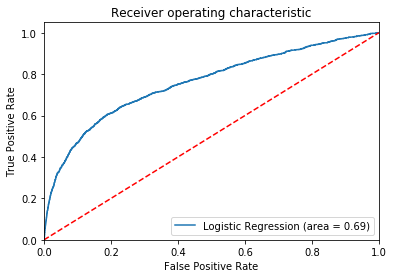

In [250]:
logit_roc_auc_s = roc_auc_score(y_test, lr_s.predict(X_test2))
fpr, tpr, thresholds = roc_curve(y_test, lr_s.predict_proba(X_test2)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc_s)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.figsize=(1000, 1000)
plt.show()